In [13]:
import numpy as np

from type_definitions.test_case import TestCase
from type_definitions.test_result import TestResult
from type_definitions.utils import *
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [14]:
seed = 100
save_plot = False

In [15]:
np.random.seed(seed)

cases = generate_cases(80)
results = evaluate_cases(cases)
[(r.score, float(r.min_alt)) for r in results if not r.simulation_failed]

Error evaluating cases: velocity (166.4730164456568) out of bounds
Error evaluating cases: alpha (2.235127964620472) out of bounds
Error evaluating cases: alpha (2.9208808170927587) out of bounds
Error evaluating cases: alpha (2.0619026474011397) out of bounds
Error evaluating cases: alpha (3.4134035915792387) out of bounds
Error evaluating cases: alpha (2.043153061530088) out of bounds
Error evaluating cases: alpha (2.265413868030235) out of bounds
Error evaluating cases: alpha (-2.6162844454297045) out of bounds
Error evaluating cases: alpha (-9.149335550413186) out of bounds
Error evaluating cases: velocity (4579.8993867091085) out of bounds
Error evaluating cases: velocity (3471.908761439921) out of bounds
Error evaluating cases: alpha (-3.7580009200070053) out of bounds
Error evaluating cases: alpha (-9.649590206823792) out of bounds
Error evaluating cases: velocity (187.0669736225547) out of bounds
Error evaluating cases: alpha (5.200527128031251) out of bounds
Error evaluating c

[(0.0, 2525.9514849901984),
 (-500.0, -2095.7118247898416),
 (-500.0, -867.0922754631333),
 (-500.0, -1721.234579282522),
 (-500.0, -899.04404861161),
 (-500.0, -1029.916905420382),
 (0.0, 3632.8329261204335),
 (0.0, 1471.8202729721575),
 (0.0, 2748.8028728669424),
 (-500.0, -1403.8138855061923),
 (0.0, 483.9836828336385),
 (-500.0, -896.2739737582018),
 (-500.0, -291.83029127326733),
 (-500.0, -410.801161152596),
 (0.0, 836.8429989024495),
 (0.0, 3944.9239497400577),
 (-500.0, -831.3599028079582),
 (0.0, 4549.110754184474),
 (0.0, 846.2966824852386),
 (0.0, 167.82743187246325),
 (-500.0, -637.3382137836782),
 (0.0, 842.5024860740982),
 (0.0, 2192.2893040062913),
 (-500.0, -2941.2521567733297),
 (-500.0, -627.8854650053404),
 (0.0, 94.33066330510175),
 (-500.0, -1865.5339485443267),
 (0.0, 770.2962295998365),
 (0.0, 4068.442421642851),
 (-500.0, -3105.5317931008894),
 (-500.0, -1734.787713271699),
 (0.0, 127.79157574644229),
 (0.6272753261988322, 2483.5185388377736),
 (6.75141377468062

In [ ]:
trajectories = [r.trajectory for r in results if not r.simulation_failed]
dim_map = {
    "pos_n": 0,
    "pos_e": 1,
    "alt": 2,
    "phi": 3,
    "theta": 4,
    "psi": 5,
    "g": 6,
}

dim_mats = {
    name: pairwise_distances([traj[:, [idx]] for traj in trajectories], n_jobs=1)
    for name, idx in dim_map.items()
}

def cluster_dbscan(D, eps=1000, min_samples=3):
    return DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed").fit_predict(D)

clusters_by_dim = {name: cluster_dbscan(D) for name, D in dim_mats.items()}

for name, labels in clusters_by_dim.items():
    counts = {int(k): int(v) for k, v in zip(*np.unique(labels, return_counts=True))}
    print(f"{name}: {counts}")



pos_n: {0: 38}
pos_e: {0: 38}
alt: {0: 38}
phi: {0: 38}
theta: {0: 38}
psi: {0: 38}
g: {0: 38}


In [23]:
active_dim = "phi"  # change to any key in dim_map
distance_matrix = dim_mats[active_dim]
clusters = clusters_by_dim[active_dim]
unique_clusters = np.unique(clusters)

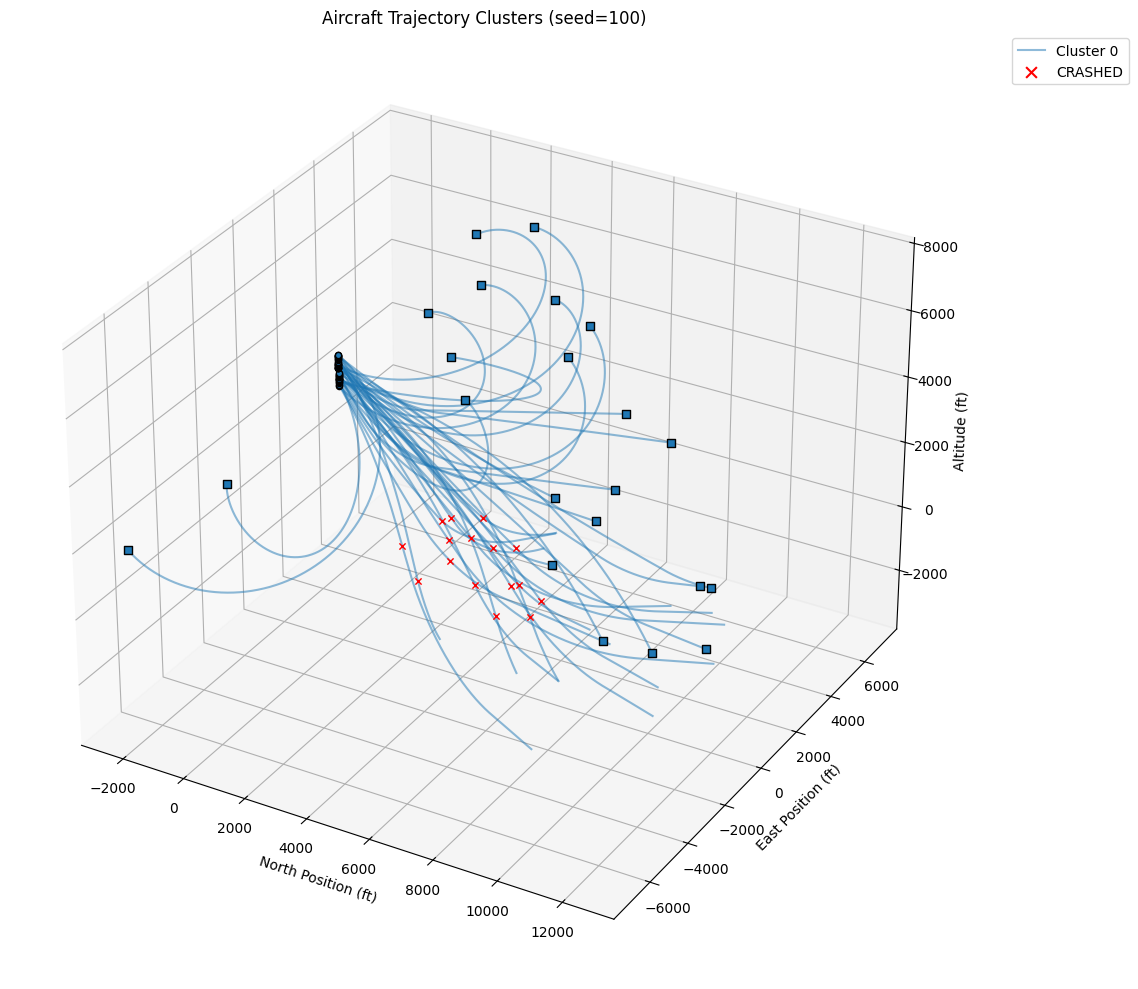

In [24]:

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

valid_results = [r for r in results if not r.simulation_failed]

plotted_clusters = set()
plotted_noise = False

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # noise points in DBSCAN
        color = "black"
        if not plotted_noise:
            label = "Noise"
            plotted_noise = True
        else:
            label = None
    else:
        color = colors[cluster_id % len(colors)]
        if cluster_id not in plotted_clusters:
            label = f"Cluster {cluster_id}"
            plotted_clusters.add(cluster_id)
        else:
            label = None

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle="-",
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # ax.scatter(
        #     traj[-1, 0],
        #     traj[-1, 1],
        #     traj[-1, 2],
        #     color="red",
        #     s=30,
        #     marker="s",
        #     edgecolor="black",
        #     linewidth=1,
        # )
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )

        # ax.text(
        #     crash_x,
        #     crash_y,
        #     crash_z + 500,
        #     f"{i}",
        #     color="red",
        #     fontsize=10,
        #     fontweight="bold",
        #     ha="center",
        #     va="bottom",
        # )
    else:
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_3d.png")
    print(f"Plot saved to results/{seed}_clusters_3d.png")

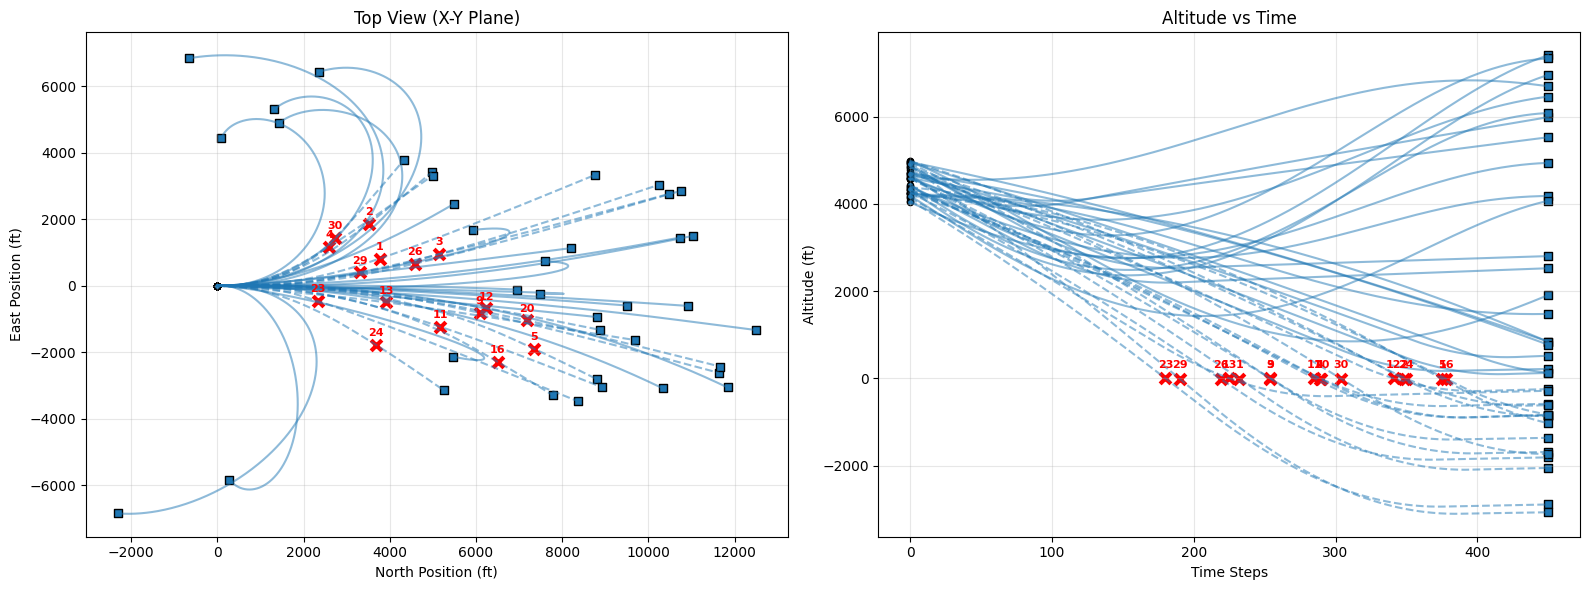

In [18]:
# 2D plotting - x-y plane and altitude vs time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# x-y plane
ax1 = axes[0]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:
        color = "black"
    else:
        color = colors[cluster_id % len(colors)]

    if result.crashed:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle="--",
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]

        ax1.scatter(
            crash_x,
            crash_y,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax1.text(
            crash_x,
            crash_y + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle="-",
        )

    ax1.scatter(
        traj[0, 0],
        traj[0, 1],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax1.scatter(
        traj[-1, 0],
        traj[-1, 1],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax1.set_xlabel("North Position (ft)")
ax1.set_ylabel("East Position (ft)")
ax1.set_title("Top View (X-Y Plane)")
ax1.grid(True, alpha=0.3)

# altitude vs time
ax2 = axes[1]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:
        color = "black"
    else:
        color = colors[cluster_id % len(colors)]

    time_steps = np.arange(len(traj))

    if result.crashed:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle="--",
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_time = time_steps[crash_idx]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_time = time_steps[min_alt_idx]
            crash_z = traj[min_alt_idx, 2]

        ax2.scatter(
            crash_time,
            crash_z,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax2.text(
            crash_time,
            crash_z + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle="-",
        )

    ax2.scatter(
        0,
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax2.scatter(
        len(traj) - 1,
        traj[-1, 2],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Altitude (ft)")
ax2.set_title("Altitude vs Time")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_2d.png")
    print(f"2D plots saved to results/{seed}_clusters_2d.png")